# An Introduction to Experimental Design with Emukit

## Overview

In [1]:
# General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Figure config
LEGEND_SIZE = 15

### Navigation

1. [What is experimental design?](#1.-What-is-experimental-design?)

2. [The ingredients of experimental design](#2.-The-ingredients-of-experimental-design)

3. [Emukit's experimental design interface](#3.-Emukit's-experimental-design-interface)

4. [References](#4.-References)

## 1. What is experimental design?

Consider a function $f: \mathbb{X} \rightarrow \mathbb{R}$, $x\mapsto f(x)$ which is defined in some constrained input space $\mathbb{X}$. The function might be unknown, and we may only learn about it by querying it at some locations $x$ to obtain (possibly noisy) measurements $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, \sigma^2_{noise})$.
*Experimental design* (ExpDesign) tries to predict the function $f(x)$ as accurately as possible also in locations where it has not been observed. This is especially useful if one needs to know the value of $f$ at a particular point $x_{new}$ but it would take too long in real life to evaluate $f$. This happens for example when $f(x)$ is the output of a time-consuming computer simulation, and a decision that needs to be made depends on the value $f(x_{new})$. 
An example of such a scenario might be a simulation of a tsunami [[Saito, 2019]](#4.-References) 
that is being run whenever an earthquake happens, in order to decide if inhabited regions need to be evacuated, and there is just not enough time to query the precise but expensive simulation. The function $f(x)$ in this case might describe the severity of the tsunami (wave height), and the inputs $x$ might describe physical measurement on the ocean ground.
An *emulator* for the function $f$ that can be queried instead of the simulation, and would give an approximate answer with a calibrated error bar which can be used to make the decision instead. For this, the emulator first needs to be trained on "datapoints" which are the results of previous simulation runs of $f$.

To make an emulator as reliable and functional as possible, the aim is to learn the function $f$ as well as possible given some limited number of function evaluations.

There are two crucial bits in experimental design:

   - A prior probability measure $p(f)$ which captures our prior beliefs on $f$, called the model. Everytime we observe new data $D$ the prior will be updated to a 'posterior' $p(f|D)$ using the available data. Obtaining the data $D$ would require running the costly simulation.

   - An acquisition function $a: \mathbb{X} \rightarrow \mathbb{R}$ which for each point in the input space quantifies the utility of evaluating this point. The central idea of the acquisition function is that the next point that will be acquired should be maximally informative to learn $f$.

Given these ingredients, ExpDesign essentially iterates the following three steps: 
1. fit the model $p(f|D_{n})$ on the currently available data $D_{n}$.
2. find the most interesting point to evaluate by $x_{n+1} \in  \operatorname*{arg\:max}_{x \in \mathbb{X}} a_n(x)$
3. evaluate the objective function at $x_{n+1}$, obtain $y_{n+1}$ and add the new observation to the data $D_{n+1} \leftarrow D_{n} \cup \{x_{n+1}, y_{n+1}\}$.


## 2. The ingredients of experimental design

<h4 id='bo_intro_objective'>The Objective Function and the Input Space</h4>

As an example let's assume we want to learn the one-dimensional forrester function: 

$$
f(x) = (6x - 2)^2\sin(12x - 4)
$$

which is defined over the interval $x \in [0, 1]$. In this example we know the functional form of $f$, but in practice we may not.

Conviently, this function is already implemented in Emukit. Note that in order to pass it to other Emukit modules we wrap the function by the UserFunctionWrapper interface.

In [2]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

target_function, space = forrester_function()

The `space` object defines the input space $X = [0, 1]$, which in this case is purely continuous and only one dimensional. We may also apply experimental design in other domains that contain discrete or categorical parameters.

Of course in reality, evaluating $f$ on a grid wouldn't be possible, but since the forrester function is a synthetic function we can evaluate it here for visualization purposes.

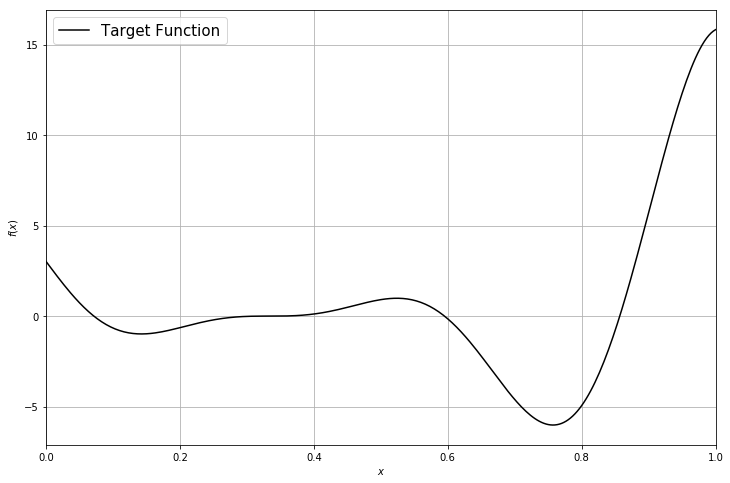

In [3]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 301)[:, None]
y_plot = target_function(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, "k", label="Target Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_init_design'> The Intial Design </h4>

Usually, before we start the actual ExpDesign loop we need to gather a few observations such that we can fit the model. This is called the initial design and common strategies are either a predefined grid or sampling points uniformly at random. 

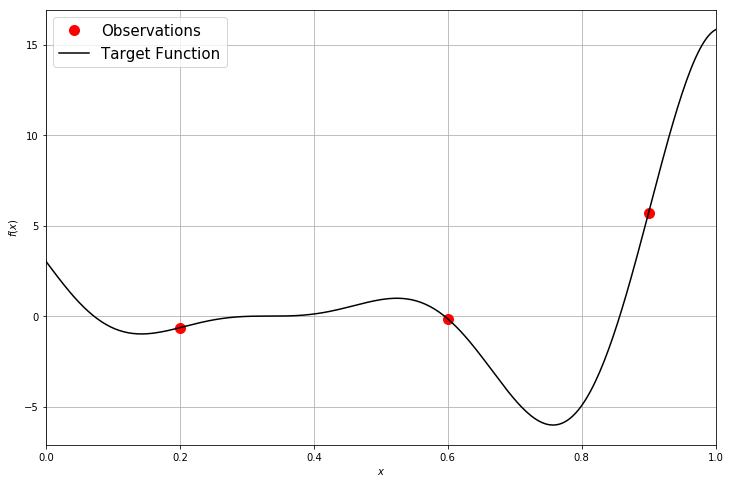

In [4]:
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Target Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_model'> The Model </h4>
        

Now we can start with the ExpDesign loop by first fitting a model on the collected data. 
A popular model for ExpDesign is a Gaussian process (GP) which defines a probability distribution across classes of functions, typically smooth, such that each linear finite-dimensional restriction is multivariate Gaussian [(Rasmussen and Williams, 2006)](#4.-References). GPs are fully parametrized by a mean $\mu(x)$ and a covariance function $k(x,x')$.  Without loss of generality $\mu(x)$ is assumed to be zero. The covariance function $k(x,x')$ characterizes the smoothness and other properties of $f$. It is known that the kernel of the process has to be continuous, symmetric and positive definite. A widely used kernel is the squared exponential or RBF kernel: $$ k(x,x') = \theta_0 \cdot \exp{ \left(-\frac{\|x-x'\|^2}{\theta_1}\right)} $$ where $\theta_0$ and and $\theta_1$ are hyperparameters.
To denote that $f$ is a sample from a GP with mean $\mu$ and covariance $k$ we write
$$f \sim \mathcal{GP}(\mu,k).$$ 

For regression tasks, the most important feature of GPs is that process priors are conjugate to the likelihood from finitely many observations $Y = (y_1,\dots,y_n)^T$ and $X =\{x_1,...,x_n\}$, $x_i\in \mathcal{X}$ of the form $y_i = f(x_i) + \epsilon_i$ where $\epsilon_i \sim \mathcal{N} (0,\sigma_{noise}^2)$ and we estimate $\sigma_{noise}$ by an additional hyperparameter $\theta_2$.
We obtain the Gaussian posterior $f(x^*)|X, Y, \theta \sim \mathcal{N}(\mu(x^*),\sigma^2(x^*))$, where $\mu(x^*)$ and $\sigma^2(x^*)$ have a close form. See [(Rasmussen and Williams, 2006)](#4.-References) for more details.

Note that Gaussian processes are also characterized by hyperparameters $\theta = \{\theta_0, ... \theta_k\}$ such as for instance the kernel lengthscales. For simplicitly we keep these hyperparameters fixed here. However, we usually either optimize or sample these hyperparameters using the marginal loglikelihood of the GP. Of course we could also use any other model that returns a mean $\mu(x)$ and variance $\sigma^2(x)$ on an arbitrary input points $x$ such as Bayesian neural networks or random forests.

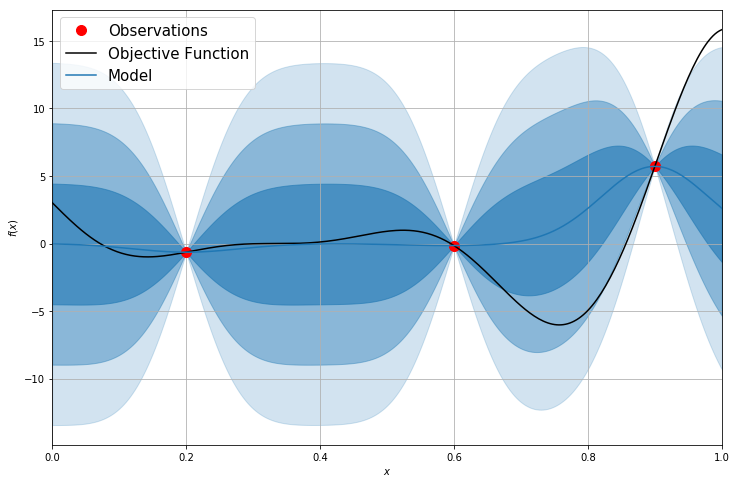

In [5]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_acquisition'> The Acqusition Function </h4>

In the second step of our ExpDesign loop we use our model to compute the acquisition function. Two example of ExpDesign acquisition functions are:


**Uncertainty Sampling (US)**: Choose the next value $x_{n+1}$ at the location where the model on $f(x)$ has the highest marginal predictive variance

$$
a_{US}(x) = \sigma^2(x)
$$ 

This makes sure, that we learn the function $f$ everywhere on $\mathbb{X}$ to a similar level of absolute error.


**Integrated variance reduction (IVR)**: Choose the next value $x_{n+1}$ such that the total variance of the model is reduced maximally [[Sacks et al. 1989]](#4.-References).

$$
a_{IVR} = \int_{\mathbb{X}}[\sigma^2(x') - \sigma^2(x'; x)]\mathrm{d}x'\approx 
\frac{1}{\# samples}\sum_i^{\# samples}[\sigma^2(x_i) - \sigma^2(x_i; x)].
$$

Here $\sigma^2(x'; x)$ is the predictive variance at $x'$ had $x$ been observed. Thus IVR compute the overall reduction in variance (for all points in $\mathbb{X}$) had $f$ been observed at $x$.
The finite sum approximation on the right hand side of the equation is usually used because the integral over $x'$ is not analytic. In that case $x_i$ are sampled randomly. For a GP model the right hand side simplifies to $a_{LCB} \approx \frac{1}{\# samples}\sum_i^{\# samples}\frac{k^2(x_i, x)}{\sigma^2(x)}$.

IVR is arguably te more principled approach, but often US is preferred over IVR simply because it lends itself to gradient based optimization more easily, is cheaper to compute, and is exact. 
For both of them (stochastic) gradient base optimizers are used to retrieve $x_{n+1} \in \operatorname*{arg\:max}_{x \in \mathbb{X}} a(x)$. 

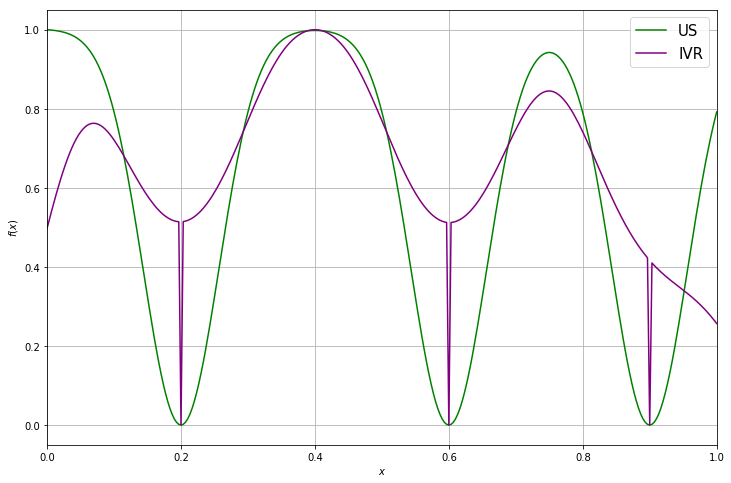

In [6]:
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

us_acquisition = ModelVariance(emukit_model)
ivr_acquisition = IntegratedVarianceReduction(emukit_model, space)

us_plot = us_acquisition.evaluate(x_plot)
ivr_plot = ivr_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, us_plot / np.max(us_plot), "green", label="US")
plt.plot(x_plot, ivr_plot / np.max(ivr_plot) , "purple", label="IVR")

plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_eval'> Evaluating the objective function </h4>

To find the next point to evaluate we optimize the acquisition function using a standard gradient descent optimizer.

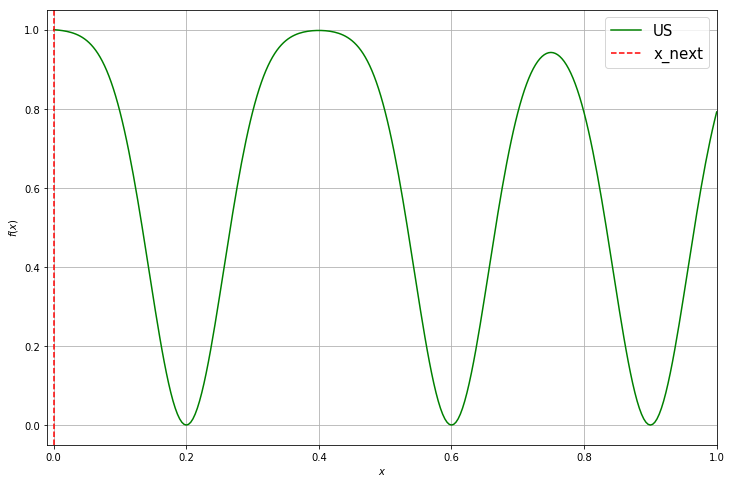

In [7]:
from emukit.core.optimization import GradientAcquisitionOptimizer

optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(us_acquisition)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, us_plot / np.max(us_plot), "green", label="US")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(-0.01, 1)
plt.show()

Afterwards we evaluate the true objective function and append it to our initial observations.

In [8]:
y_new = target_function(x_new)

In [9]:
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

After updating the model, you can see that the uncertainty about the true objective function in this region decreases and our model becomes more certain.

In [10]:
emukit_model.set_data(X, Y)

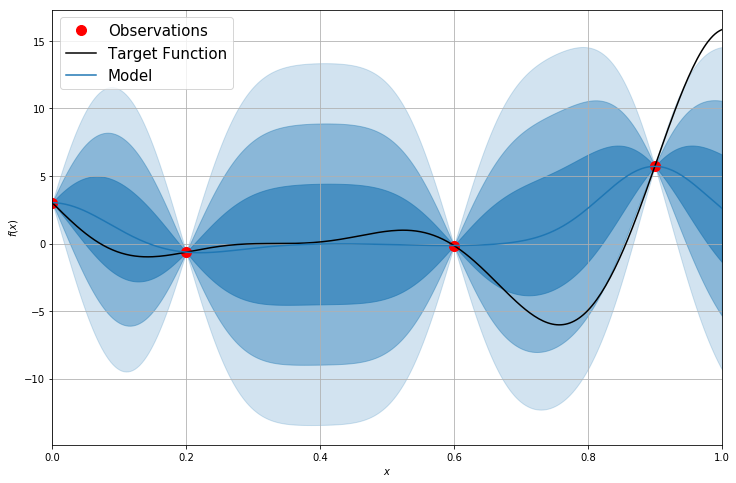

In [11]:
mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Target Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

## 3. Emukit's experimental design interface

Of course in practice we don't want to implement all of these steps our self. Emukit provides a convenient and flexible interface to apply experimental design. Below we can see how to run experimental design on the exact same function for 10 iterations.

In [12]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop

ed = ExperimentalDesignLoop(space=space, model=emukit_model)

ed.run_loop(target_function, 10)

Optimization restart 1/1, f = 10.389046310690773
Optimization restart 1/1, f = 12.430645421282618
Optimization restart 1/1, f = 14.401713059514762
Optimization restart 1/1, f = 18.27927905465763
Optimization restart 1/1, f = 20.356481039870744
Optimization restart 1/1, f = 28.894340531087423
Optimization restart 1/1, f = 31.59183877266898
Optimization restart 1/1, f = 34.50383358105009
Optimization restart 1/1, f = 26.515314304617206
Optimization restart 1/1, f = 25.486082708992214
Optimization restart 1/1, f = 23.697850766802002


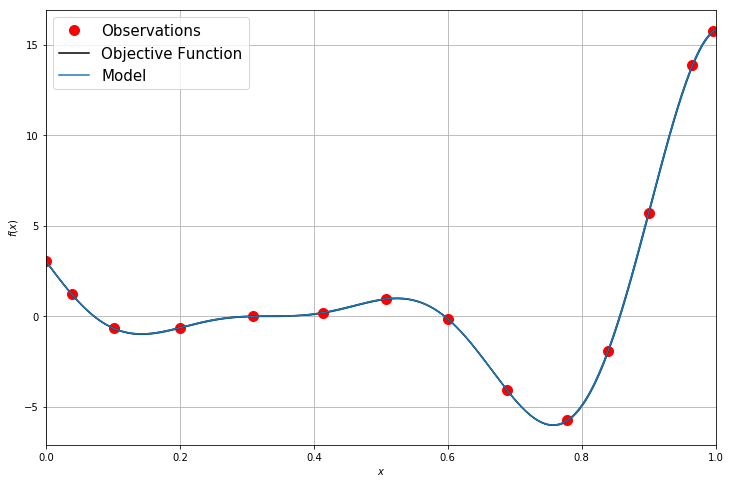

In [13]:
mu_plot, var_plot = ed.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(ed.loop_state.X, ed.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)

plt.show()

## 4. References

- Saito, T. *Tsunami Generation and Propagation* Springer Geophysics, 2019

- Rasmussen, C. E. and Williams, C. K. I., 2005. *Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning.* The MIT Press, 2005

- Sacks, J., Welch, W., Mitchell, T.J. and Wynn, H. *Design and Analysis of Computer Experiments*, Statistical Science, 1989